# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


C:\Users\hira\AppData\Local\Temp\ipykernel_15164\3876000646.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


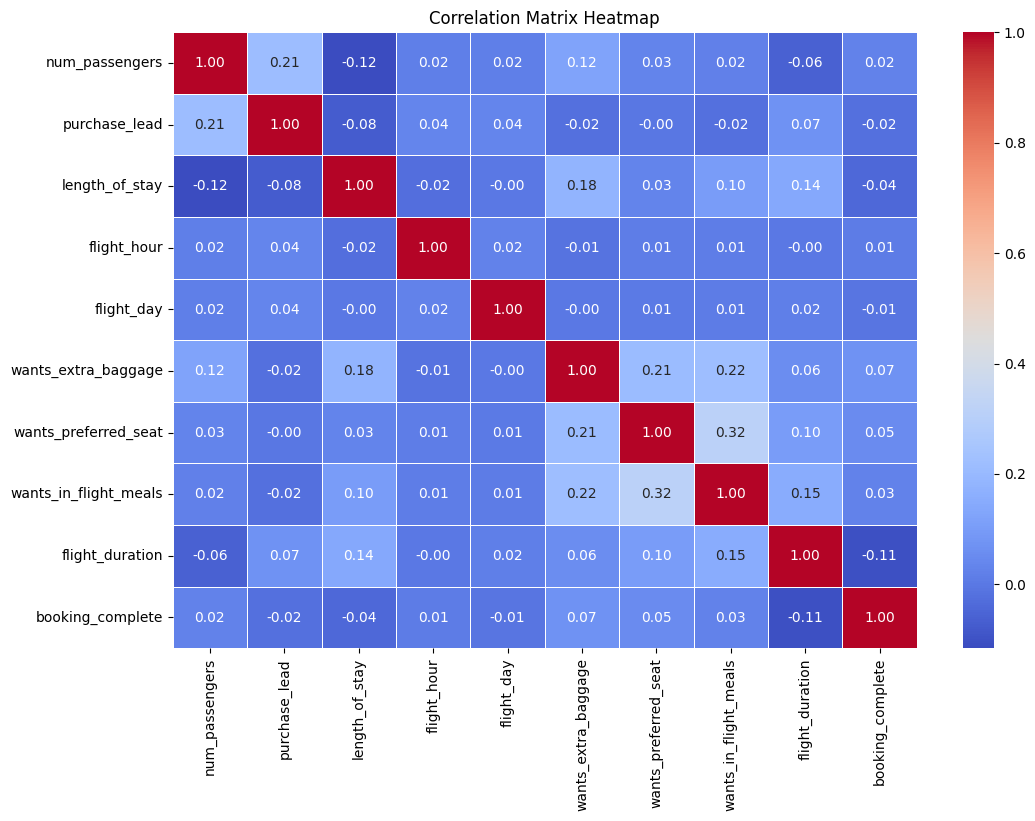

In [9]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [10]:
# check which columns having string values
j = 0
for i in df.columns:
    if df[i].dtype == "object":
        print(i, df[i].value_counts())
        j = j + 1

print(j)

sales_channel Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64
trip_type RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64
route AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: route, Length: 799, dtype: int64
booking_origin Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: booking_origin, Length: 104, dtype: int64
4


In [11]:
data = df.copy()

In [12]:
# change string values to numeric
data["sales_channel"] = data["sales_channel"].astype("category").cat.codes

In [13]:

# Calculate the frequency of each 'route' and create a categorical dictionary
data["route"] = data["route"].astype("category").cat.codes

In [14]:
data["trip_type"] = data["trip_type"].astype("category").cat.codes
data['booking_origin'] = data['booking_origin'].astype('category').cat.codes

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  int8   
 2   trip_type              50000 non-null  int8   
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  int16  
 8   booking_origin         50000 non-null  int8   
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int16(1), int64(9), int8(3)
memory usag

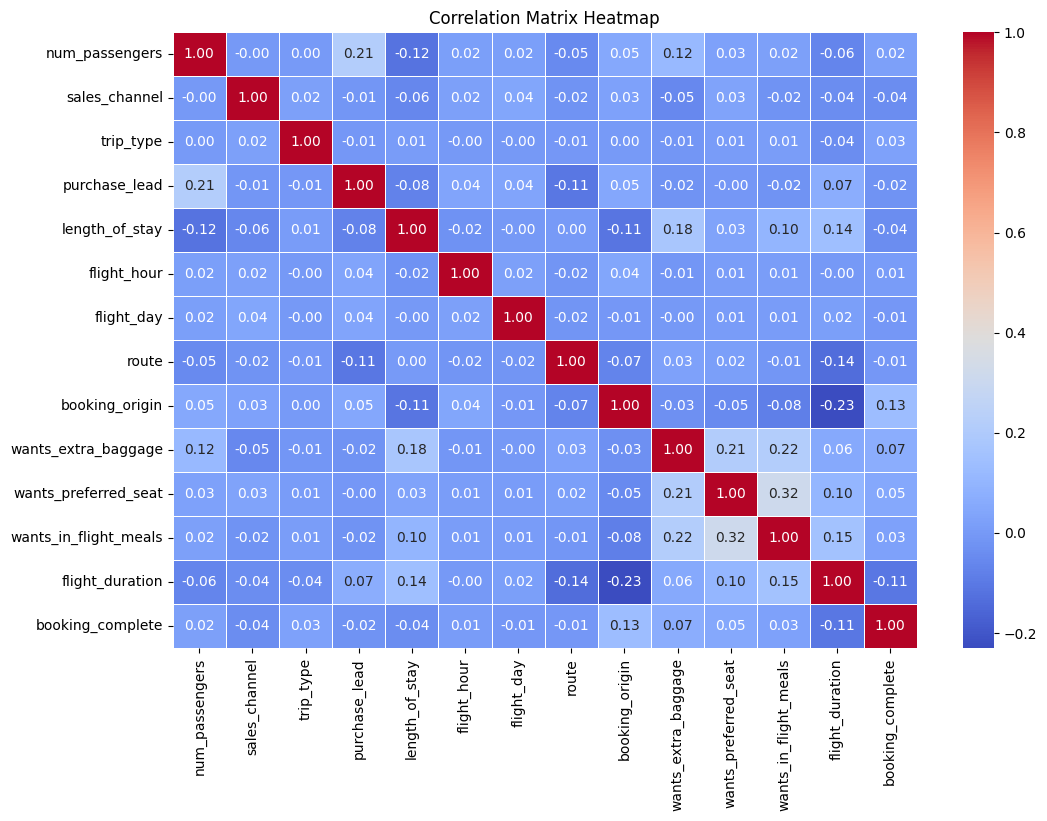

In [16]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [17]:
data['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [18]:
for i in data.columns:
    if data[i].dtype != "int64" and data[i].dtype != "float64":
        print(i, len(data[i].unique()))

sales_channel 2
trip_type 3
route 799
booking_origin 104


In [19]:
data.flight_hour.value_counts()

8     3165
12    3163
9     3132
7     3126
11    3110
13    3101
10    3085
6     3050
5     2851
4     2843
14    2833
3     2655
2     2642
15    2234
1     2089
16    1557
0     1539
23     986
17     861
22     579
18     439
21     389
19     295
20     276
Name: flight_hour, dtype: int64

In [20]:
day_start_hour = 6
day_end_hour = 18
data['day_portion'] = data['flight_hour'].apply(lambda x: 1 if day_start_hour <= x < day_end_hour else 0)

In [21]:
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,day_portion
0,2,0,2,262,19,7,6,0,61,1,0,0,5.52,0,1
1,1,0,2,112,20,3,6,0,61,0,0,0,5.52,0,0
2,2,0,2,243,22,17,3,0,36,1,1,0,5.52,0,1
3,1,0,2,96,31,4,6,0,61,0,0,1,5.52,0,0
4,2,0,2,68,22,15,3,0,36,1,0,1,5.52,0,1


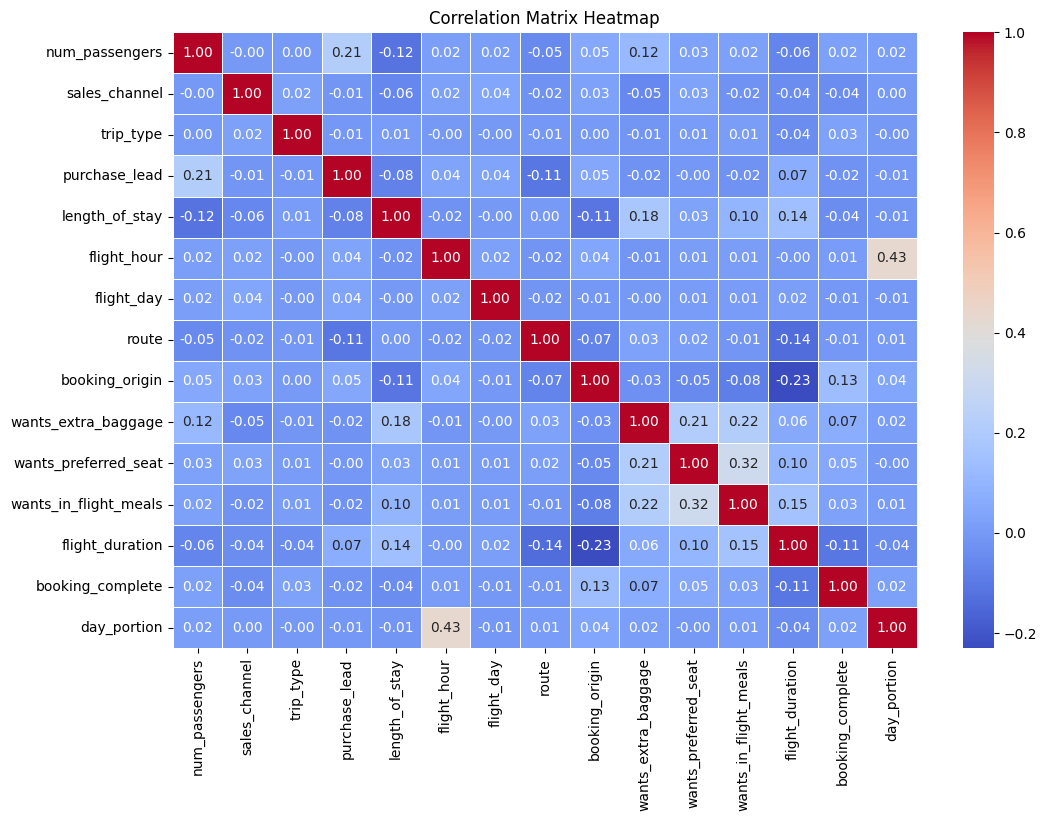

In [22]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [23]:
# Select features with a positive or zero correlation with the target
positive_correlation_features = correlation_matrix[correlation_matrix['booking_complete'] >= 0].index

# Create a new DataFrame with only the selected features
df_filtered = data[positive_correlation_features]
df_filtered.columns

Index(['num_passengers', 'trip_type', 'flight_hour', 'booking_origin',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'booking_complete', 'day_portion'],
      dtype='object')

In [24]:
df_filtered

,num_passengers,trip_type,flight_hour,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,booking_complete,day_portion
0,2,2,7,61,1,0,0,0,1
1,1,2,3,61,0,0,0,0,0
2,2,2,17,36,1,1,0,0,1
3,1,2,4,61,0,0,1,0,0
4,2,2,15,36,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...
49995,2,2,9,4,1,0,1,0,1
49996,1,2,4,4,0,0,0,0,0
49997,1,2,22,4,0,0,1,0,0
49998,1,2,11,4,1,0,1,0,1


In [25]:
X = df_filtered.drop(["booking_complete", "flight_hour"], axis=1)
y = df_filtered["booking_complete"]

In [26]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 7), (10000, 7), (40000,), (10000,))

In [27]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [28]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy Score:  0.8472
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.35      0.04      0.07      1480

    accuracy                           0.85     10000
   macro avg       0.60      0.51      0.49     10000
weighted avg       0.78      0.85      0.79     10000



In [29]:
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Confusion Matrix: 
 [[8416  104]
 [1424   56]]


In [30]:
# Evaluate the model using cross-validation
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5)  # 5-fold cross-validation, you can change the number as needed
mean_accuracy = np.mean(cross_val_scores)

# Output the mean accuracy
print(f"Mean Accuracy: {mean_accuracy}")

Mean Accuracy: 0.8440249999999999


In [33]:
mean_accuracy = np.mean(cross_val_scores)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cross-Val Score', 'Roc_Curve'])
results.loc["Random Forest"] = [acc, prec, rec, f1, mean_accuracy, roc_auc]
results

,Accuracy,Precision,Recall,F1 Score,Cross-Val Score,Roc_Curve
Random Forest,0.8472,0.35,0.037838,0.068293,0.844025,0.512816


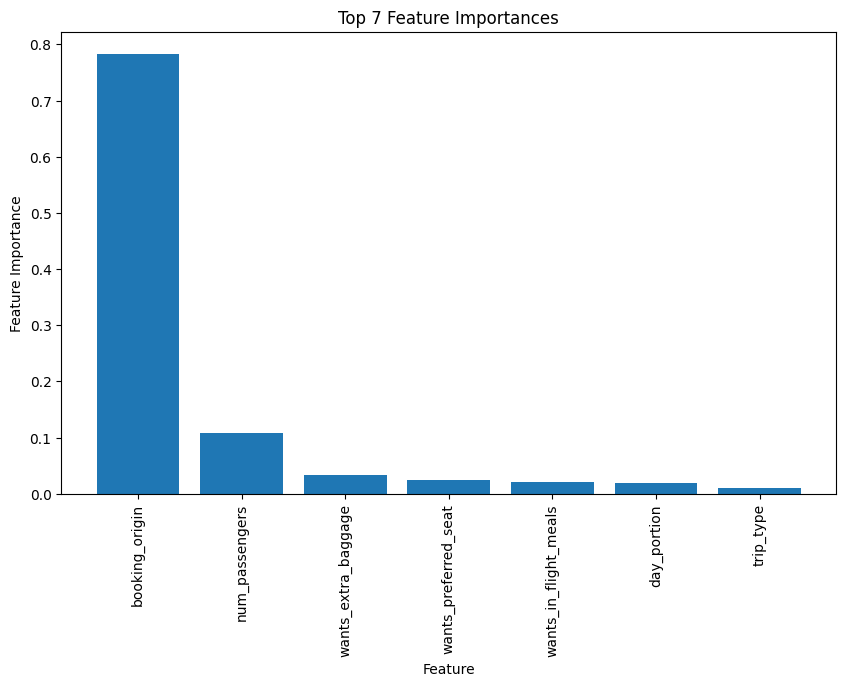

In [35]:
# Visualize feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the top N important features
top_n = 7  # You can change this to visualize more or fewer features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[sorted_idx][:top_n], align="center")
plt.xticks(range(top_n), np.array(feature_names)[sorted_idx][:top_n], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Top {} Feature Importances".format(top_n))
plt.show()

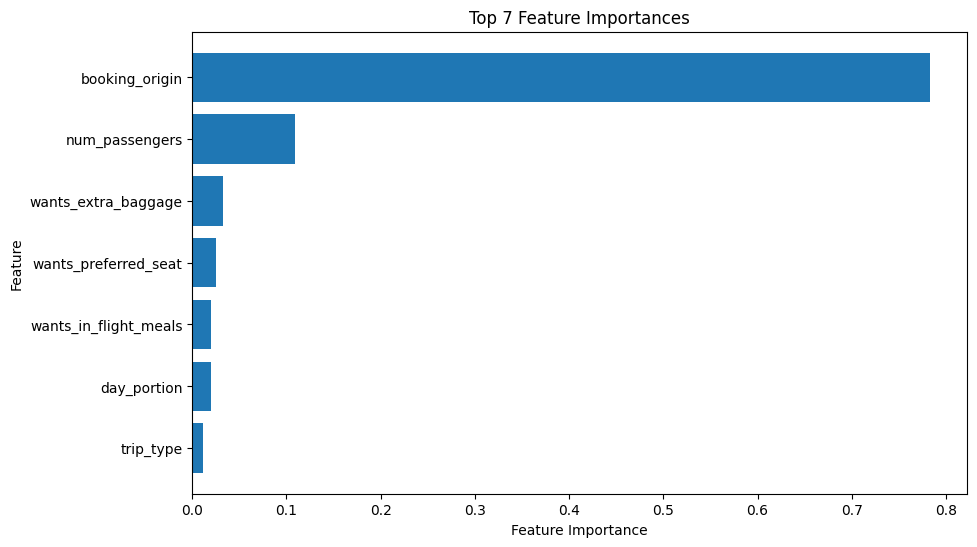

In [39]:
# Visualize feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the top N important features as a horizontal bar graph
top_n = 7  # You can change this to visualize more or fewer features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importances[sorted_idx][:top_n], align="center")
plt.yticks(range(top_n), np.array(feature_names)[sorted_idx][:top_n])
plt.xlabel("Feature Importance", )
plt.ylabel("Feature")
plt.title("Top {} Feature Importances".format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

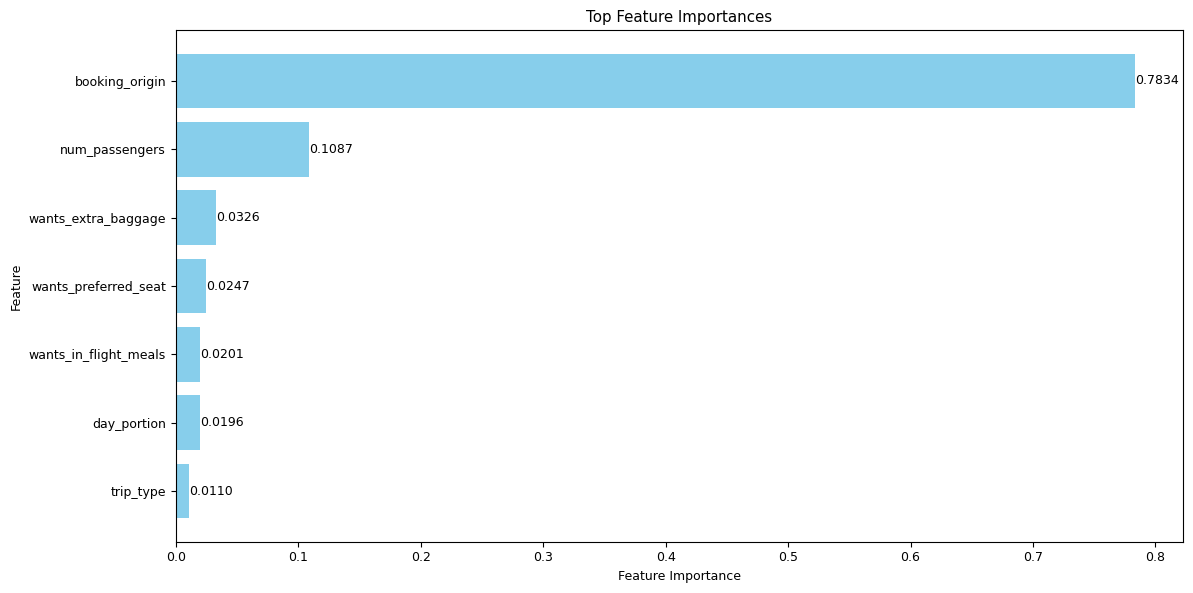

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the top N important features as a horizontal bar graph
top_n = 7  # You can change this to visualize more or fewer features

# Set a custom font size
plt.rc('font', size=9)

fig, ax = plt.subplots(figsize=(12, 6))
bar_color = 'skyblue'  # Define a single color for the bars
bars = ax.barh(range(top_n), feature_importances[sorted_idx][:top_n], align="center", color=bar_color)
plt.yticks(range(top_n), np.array(feature_names)[sorted_idx][:top_n])

plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top

# Adding data values on the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', ha='left', va='center')

plt.tight_layout()  # Ensure labels fit in the plot area
plt.show()

In [55]:
# Sort features by importance
sorted_idx = np.argsort(feature_importances)

# Topmost feature
top_feature = np.array(feature_names)[sorted_idx][-1]
top_importance = feature_importances[sorted_idx][-1]

# Lowest feature
lowest_feature = np.array(feature_names)[sorted_idx][0]
lowest_importance = feature_importances[sorted_idx][0]

# Print the topmost and lowest features and their importances
print("From Feature Importances: \n")
print(f"- {top_feature} is most important feature of the model.")
print(f"- {lowest_feature} is not important feature.")

From Feature Importances: 

- booking_origin is most important feature of the model.
- trip_type is not important feature.


# 2nd Method

In [ ]:
copy_df = df.copy()
copy_df.head()

In [ ]:
# Create a dictionary to map flight_hour to day_portion
hour_to_day_portion = {
    0: "night",
    1: "night",
    2: "night",
    3: "night",
    4: "night",
    5: "night",
    6: "morning",
    7: "morning",
    8: "morning",
    9: "morning",
    10: "morning",
    11: "morning",
    12: "afternoon",
    13: "afternoon",
    14: "afternoon",
    15: "afternoon",
    16: "afternoon",
    17: "evening",
    18: "evening",
    19: "evening",
    20: "evening",
    21: "night",
    22: "night",
    23: "night",
}

# Map flight_day to is_weekend
copy_df["is_weekend"] = copy_df["flight_day"].map(lambda x: 1 if x >= 6 else 0)

# Map flight_hour to day_portion
copy_df["day_portion"] = copy_df["flight_hour"].map(hour_to_day_portion)

In [ ]:
copy_df.head()

In [ ]:
weekend = copy_df.groupby('is_weekend')['num_passengers'].sum().reset_index()
ax = sns.barplot(data = weekend, x= 'is_weekend', y= 'num_passengers')
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
dayperday = df.groupby('flight_day')['num_passengers'].mean().reset_index()

ax = sns.barplot(data = dayperday, x= 'flight_day', y= 'num_passengers')
for bar in ax.patches:
    bar.set_facecolor('#888888')

ax.bar_label(ax.containers[0])
plt.ylim(0,2)
ax.patches[5].set_facecolor('#aa3333')
ax.patches[6].set_facecolor('#aa3333')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Apply label encoding to each object column
for col in copy_df.columns:
  if copy_df[col].dtype == 'object':
    # print(copy_df[col])
    copy_df[col] = label_encoder.fit_transform(copy_df[col])

copy_df.head()

In [ ]:
# Calculate the correlation matrix
copy_correlation_matrix = copy_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
# Select features with a positive or zero correlation with the target
positive_correlation_features = correlation_matrix[copy_correlation_matrix['booking_complete'] >= 0].index

# Create a new DataFrame with only the selected features
copy_df_filtered = data[positive_correlation_features]
copy_df_filtered.columns

In [ ]:
X_copy = copy_df_filtered.drop("booking_complete", axis=1)
y_copy = copy_df_filtered["booking_complete"]

In [ ]:
# split data into train and test sets
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(X_copy, y_copy, random_state=42, test_size=0.2)
X_train_copy.shape, X_test_copy.shape, y_train_copy.shape, y_test_copy.shape

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_copy, y_train_copy)
y_pred_copy = rf.predict(X_test_copy)

In [ ]:
print("Accuracy Score: ", accuracy_score(y_test_copy, y_pred))
print("Classification Report: \n", classification_report(y_test_copy, y_pred_copy))

In [ ]:
print("Confusion Matrix: \n", confusion_matrix(y_test_copy, y_pred_copy))

In [ ]:
# Evaluate the model using cross-validation
cross_val_scores = cross_val_score(rf, X_train_copy, y_train_copy, cv=5)  # 5-fold cross-validation, you can change the number as needed
mean_accuracy = np.mean(cross_val_scores)

# Output the mean accuracy
print(f"Mean Accuracy: {mean_accuracy}")

In [ ]:
# Visualize feature importances
feature_importances = rf.feature_importances_
feature_names = X_copy.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot the top N important features
top_n = 7  # You can change this to visualize more or fewer features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[sorted_idx][:top_n], align="center")
plt.xticks(range(top_n), np.array(feature_names)[sorted_idx][:top_n], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Top {} Feature Importances".format(top_n))
plt.show()